In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import transforms

import torch.nn as nn # torch.nn module, contains classes and functions to help build neural networks

import torch.optim as optim # provides various optimization algorithms, such as SGD (Stochastic Gradient Descent), Adam, etc
from torch.utils.data import DataLoader, TensorDataset # Dataloader - helps to load data, TensorDataset - allows to access data points as pairs(i/p, target)

from scipy.special import softmax
from sklearn.metrics import confusion_matrix, accuracy_score


# Downloading the MNIST digit datasets

In [2]:
# Ensuring one-hot format
def one_hot_encoder(x):
  temp_array = np.zeros(10, dtype=float) # numpy arrays of zeros with length 10, 0 through 9
  temp_array[x] = 1 # element at index x in the temp array set to 1
  return temp_array

# To normalize the input
def transform(x):
  return np.array(x)/255.0

In [3]:
train_data = datasets.MNIST(root='./data', train = True , download=True, transform=transform, target_transform = one_hot_encoder)
test_data = datasets.MNIST(root='./data', train = False ,download=True, transform=transform, target_transform = one_hot_encoder)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 50035215.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1852851.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 6123926.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3924707.20it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
len(train_data)

60000

In [5]:
len(test_data)

10000

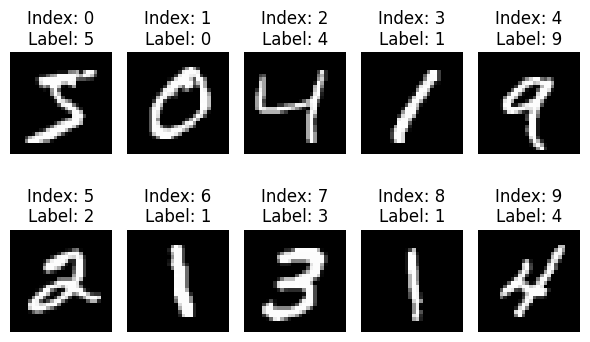

In [6]:
# Visualizing the data
fig, axes = plt.subplots(2, 5, figsize=(6, 4))  # 2 rows, 5 columns
for i in range(10): # Loop through the first 10 images
  ax = axes[i // 5, i % 5]  # Determine the position of the subplot (row, column)

  ax.imshow(train_data.data[i], cmap='gray')
  ax.set_title(f"Index: {i}\nLabel: {train_data.targets[i].item()}") # Set the title to show the index and label
  ax.axis('off')

plt.tight_layout() # prevents from overlay
plt.show()

In [7]:
# organize the data in batches
# want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
len(train_dataloader)

938

In [9]:
len(test_dataloader)

157

# Code from scratch

In [10]:
input_layer = train_data.data[i].flatten().shape[0]
hidden1_layer = 500
hidden2_layer = 250
hidden3_layer = 100
out_layer = train_data.train_labels.unique().shape[0]

layers_dims = [input_layer, hidden1_layer, hidden2_layer, hidden3_layer, out_layer]


def initialize_parameters(layer_dimensions, initial):
  parameters = {}
  num_layers = len(layer_dimensions) # number of layers in the network

  for layer in range(1, num_layers):
    if initial == "glorot": # glorot intitalization
      M = np.sqrt(6*(1/(layer_dimensions[layer]+layer_dimensions[layer-1])))
      parameters['W' + str(layer)] = np.random.uniform(low = -M, high = M, size = (layer_dimensions[layer], layer_dimensions[layer-1]))
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    elif initial == "random": # Random Initialization
      parameters['W' + str(layer)] = np.random.randn(layer_dimensions[layer], layer_dimensions[layer-1]) / np.sqrt(layer_dimensions[layer-1])
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    else:  # Zero Initialization
      parameters['W' + str(layer)] = np.zeros((layer_dimensions[layer], layer_dimensions[layer-1]))
      parameters['b' + str(layer)] = np.zeros((layer_dimensions[layer], 1))

    assert(parameters['W' + str(layer)].shape == (layer_dimensions[layer], layer_dimensions[layer-1]))
    assert(parameters['b' + str(layer)].shape == (layer_dimensions[layer], 1))

  return parameters

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


#  Activation Function

In [11]:
# ReLu
def relu(x):
  return np.maximum(x, 0)


def relu_derivative(Z):
    return Z > 0  # This will return 1 where Z > 0, and 0 elsewhere


# Forward Propagation

In [12]:
def forward_propagation(input_data, parameters, activation_function):
    forward_propagation = {}
    num_layers = int(len(parameters) / 2)  # Total number of layers (excluding input)

    # Linear transformation for the first layer
    forward_propagation['Z1'] = np.dot(parameters['W1'], input_data) + parameters['b1']
    forward_propagation['A1'] = activation_function(forward_propagation['Z1'])

    # Loop through layers 2 to (num_layers - 1) (hidden layers)
    for layer in range(2, num_layers):
        # Activation from the previous layer
        forward_propagation['Z' + str(layer)] = np.dot(parameters['W' + str(layer)], forward_propagation['A' + str(layer - 1)]) + parameters['b' + str(layer)]
        forward_propagation['A' + str(layer)] = activation_function(forward_propagation['Z' + str(layer)])

    # For the final layer, apply softmax directly to the output
    forward_propagation['Z' + str(num_layers)] = np.dot(parameters['W' + str(num_layers)], forward_propagation['A' + str(num_layers - 1)]) + parameters['b' + str(num_layers)]
    forward_propagation['A' + str(num_layers)] = softmax(forward_propagation['Z' + str(num_layers)], axis=0)

    # Store forward pass results and parameters for backpropagation
    cache = (forward_propagation, parameters)

    return forward_propagation['A' + str(num_layers)], cache


# Backpropagation

In [14]:
def back_propagation(input, labels, cache):
    num_examples = input.shape[1]  # Number of examples in the batch (m)
    forward_propagation, parameters = cache
    num_layers = len(parameters) // 2  # Number of layers (assuming W1, b1, ..., WL, bL)
    grads = {}
    grads['dZ' + str(num_layers)] = forward_propagation['A' + str(num_layers)] - labels

    for layer in range(num_layers - 1, 0, -1):
        grads['dW' + str(layer + 1)] = (1. / num_examples) * np.dot(grads['dZ' + str(layer + 1)], forward_propagation['A' + str(layer)].T)
        grads['db' + str(layer + 1)] = (1. / num_examples) * np.sum(grads['dZ' + str(layer + 1)], axis=1, keepdims=True)
        grads['dA' + str(layer)] = np.dot(parameters['W' + str(layer + 1)].T, grads['dZ' + str(layer + 1)])
        grads['dZ' + str(layer)] = grads['dA' + str(layer)] * np.where(forward_propagation['A' + str(layer)] > 0, 1, 0)  # ReLU derivative

    grads['dW1'] = 1. / num_examples * np.dot(grads['dZ1'], input.T)
    grads['db1'] = 1. / num_examples * np.sum(grads['dZ1'], axis=1, keepdims=True)

    return grads


# Update parameters

In [16]:
def update_parameters(parameters, grads, learning_rate, lambd=0):
    num_layers = len(parameters) // 2  # Number of layers in the network
    for layer in range(num_layers):
        parameters["W" + str(layer + 1)] -= (learning_rate * (grads["dW" + str(layer + 1)] + (lambd / 2) * parameters["W" + str(layer + 1)]))
        parameters["b" + str(layer + 1)] -= (learning_rate * grads["db" + str(layer + 1)])
    return parameters


# Cost Funtion

In [18]:
def cross_entropy_cost(predictions, labels):
    num_examples = labels.shape[1]

    # Compute the cross-entropy loss
    loss_per_example = -np.sum(labels * np.log(predictions), axis=0)
    average_cost = 1. / num_examples * np.sum(loss_per_example)

    return average_cost


In [20]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Accuracy and Confusion matrix

In [21]:
def accuracy(parameter, test_data, function):
  size = test_data.data.shape[0]
  img_size = test_data.data.shape[1] * test_data.data.shape[2]

  test_dataloader = next(iter(DataLoader(test_data, batch_size=size, shuffle=True)))
  X = np.swapaxes(np.array(test_dataloader[0]),0,2).reshape(img_size, size)

  pred = np.swapaxes(forward_propagation(X, parameter, function)[0], 0, 1)
  Y = np.array(test_dataloader[1])

  accuracy = accuracy_score(np.argmax(Y, axis=1), np.argmax(pred, axis=1))
  return accuracy

In [22]:
def confusion_mat(parameter, test_data, function):
  size = test_data.data.shape[0]
  img_size = test_data.data.shape[1] * test_data.data.shape[2]

  test_dataloader = next(iter(DataLoader(test_data, batch_size=size, shuffle=True)))
  X = np.swapaxes(np.array(test_dataloader[0]),0,2).reshape(img_size, size)

  pred = np.swapaxes(forward_propagation(X, parameter, function)[0], 0, 1)
  Y = np.array(test_dataloader[1])

  confu_matrix = confusion_matrix(np.argmax(Y, axis=1), np.argmax(pred, axis=1))
  return confu_matrix


# Training the model

In [23]:
def model(train_dataloader, test_data, batch_size=64, learning_rate=0.01, epoch=10, print_cost=True, lambd=0, initial="random", function=relu):
    grads = {}
    train_costs = []  # To store training costs
    test_costs = []   # To store test costs
    layers_dims = [input_layer, hidden1_layer, hidden2_layer, hidden3_layer, out_layer]
    parameters = initialize_parameters(layers_dims, initial)
    count = 0

    for i in range(epoch):
        for (batch_idx, batch) in enumerate(train_dataloader):
            batch_x, batch_y = batch
            X = np.swapaxes(np.array(batch_x), 0, 2).reshape(batch_x.shape[1]*batch_x.shape[2], batch_x.shape[0])
            Y = np.swapaxes(np.array(batch_y), 0, 1)

            # Forward propagation
            a3, cache = forward_propagation(X, parameters, function)
            train_cost = cross_entropy_cost(a3, Y)

            # Backward propagation and parameter update
            grads = back_propagation(X, Y, cache)
            parameters = update_parameters(parameters, grads, learning_rate, lambd=lambd)

            if batch_idx % 200 == 0:
                train_costs.append(train_cost)

                # Calculate test loss at every 200th batch
                test_dataloader = next(iter(DataLoader(test_data, batch_size=batch_size, shuffle=True)))
                test_x = np.swapaxes(np.array(test_dataloader[0]), 0, 2).reshape(test_dataloader[0].shape[1]*test_dataloader[0].shape[2], test_dataloader[0].shape[0])
                test_y = np.swapaxes(np.array(test_dataloader[1]), 0, 1)
                test_a3, _ = forward_propagation(test_x, parameters, function)
                test_cost = cross_entropy_cost(test_a3, test_y)
                test_costs.append(test_cost)

            if print_cost and batch_idx % 200 == 0:
                print(f"Cost after epoch {i}, iteration {batch_idx}: Train Cost: {train_cost}, Test Cost: {test_cost}")

    return parameters, train_costs, test_costs


In [24]:
def plotting(parameters, test_data, train_data, function):
    # Calculate test and train accuracy, passing the 'function' parameter
    test_acc = accuracy(parameters[0], test_data, function)
    train_acc = accuracy(parameters[0], train_data, function)

    # Generate confusion matrix for the test data
    conf_matrix = confusion_mat(parameters[0], test_data, function)

    # Create two subplots: one for the confusion matrix, one for the loss curves
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot the confusion matrix
    ax.matshow(conf_matrix, cmap='viridis', alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    ax.set_xlabel('Predicted Label', fontsize=18)
    ax.set_ylabel('True Label', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=18)

    # Plot the cost curve over iterations (training and test)
    bx.plot(range(0, len(parameters[1])), parameters[1], label='Train Loss', color='b')
    bx.plot(range(0, len(parameters[2])), parameters[2], label='Test Loss', color='r')

    bx.set_xlabel('Iteration (x 200)', fontsize=18)
    bx.set_ylabel('Loss', fontsize=18)
    bx.set_title('Training and Test Loss Over Iterations', fontsize=18)
    bx.legend()

    # Combine test and train accuracy in a label for the plot
    label = f"Test acc. = {test_acc * 100:.2f}%, Train acc. = {train_acc * 100:.2f}%"
    plt.suptitle(label, fontsize=20)

    # Show the plots
    plt.tight_layout()
    plt.show()


Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=zero
Cost after epoch 0, iteration 0: Train Cost: 3.2508297339144825, Test Cost: 3.2508857045687405
Cost after epoch 0, iteration 200: Train Cost: 3.24939795028802, Test Cost: 3.248774961892383
Cost after epoch 0, iteration 400: Train Cost: 3.251901229631395, Test Cost: 3.2517604006038594
Cost after epoch 0, iteration 600: Train Cost: 3.2440223417335554, Test Cost: 3.252955985593675
Cost after epoch 0, iteration 800: Train Cost: 3.2489579698084645, Test Cost: 3.238539087949272
Cost after epoch 1, iteration 0: Train Cost: 3.2505041051334485, Test Cost: 3.248422781727033
Cost after epoch 1, iteration 200: Train Cost: 3.2503799521085806, Test Cost: 3.2497910085123367
Cost after epoch 1, iteration 400: Train Cost: 3.2589958170135027, Test Cost: 3.25426489779948
Cost after epoch 1, iteration 600: Train Cost: 3.2495542345414776, Test Cost: 3.2491648522791547
Cost after epoch 1, iteration 800: Train Cost: 3.245617694521777

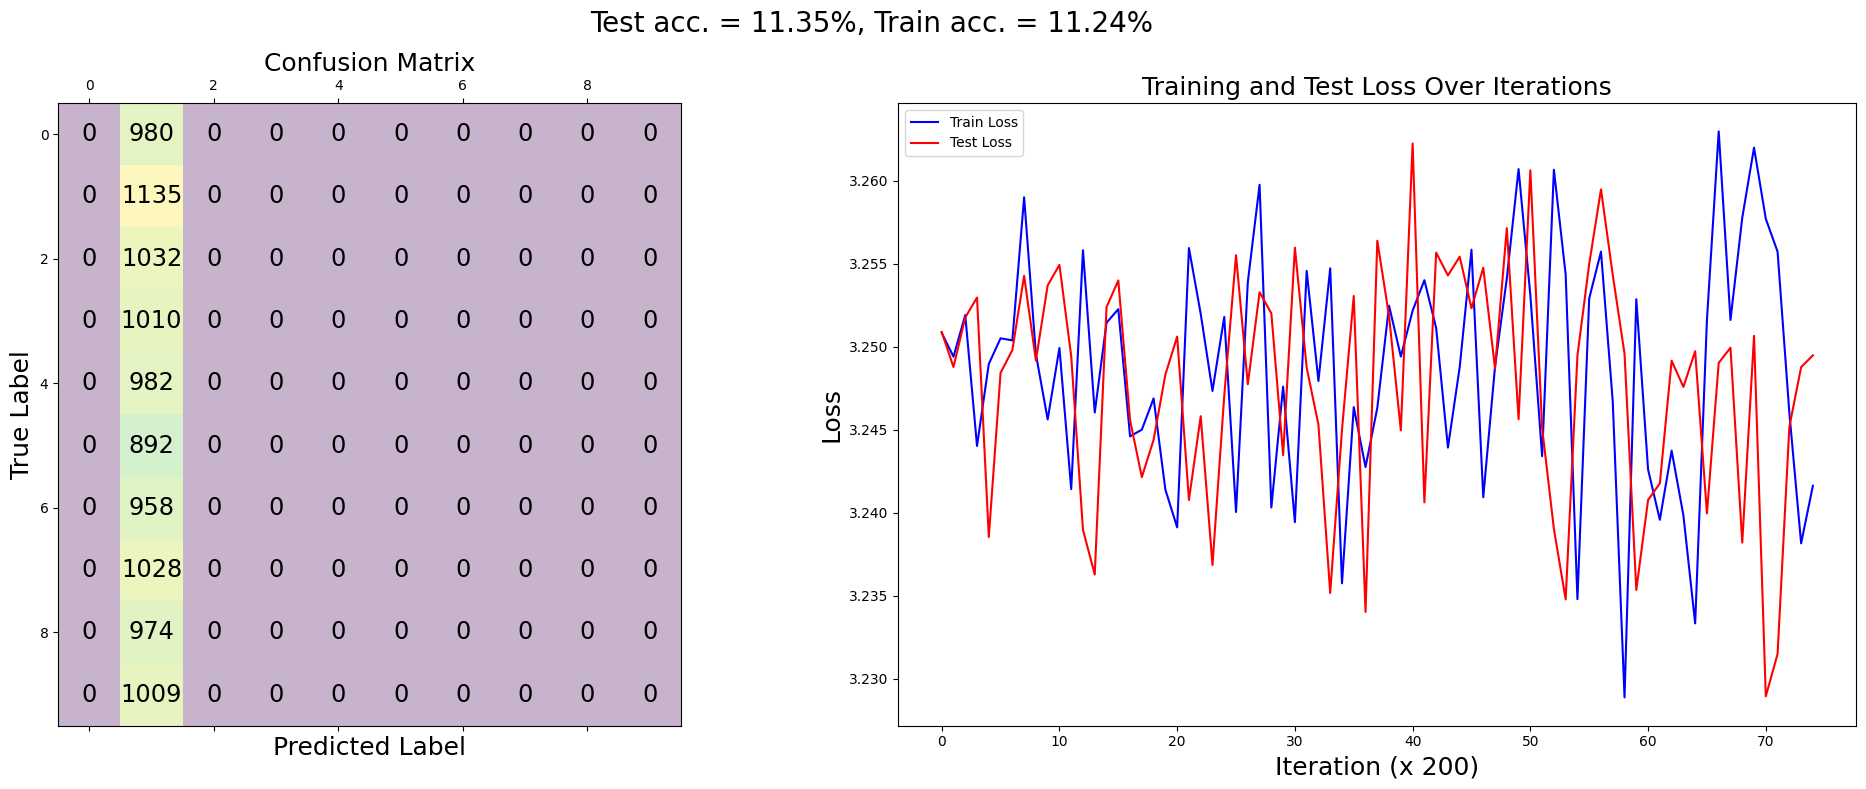

In [25]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "zero"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(train_dataloader, test_data, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch, print_cost=True, lambd=lambd, initial=initial)

# Find the model with 'zero' initialization dynamically
i = [key for key in learned_parameters.keys() if "Initilization=zero" in key][0]

# Plotting the losses and confusion matrix for the 'zero' initialization model
plotting(learned_parameters[i], test_data, train_data, relu)


In [26]:
print("Available model keys:", learned_parameters.keys())

Available model keys: dict_keys(['Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=zero'])


Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=random
Cost after epoch 0, iteration 0: Train Cost: 3.218838252648877, Test Cost: 3.249292094742902
Cost after epoch 0, iteration 200: Train Cost: 2.413697506918888, Test Cost: 2.5407890200291865
Cost after epoch 0, iteration 400: Train Cost: 1.2041585253188556, Test Cost: 1.2853892756933902
Cost after epoch 0, iteration 600: Train Cost: 1.057225404453035, Test Cost: 0.8820693913792315
Cost after epoch 0, iteration 800: Train Cost: 0.5800738218132238, Test Cost: 0.5819825938178055
Cost after epoch 1, iteration 0: Train Cost: 0.7040102898899068, Test Cost: 0.8210415228909
Cost after epoch 1, iteration 200: Train Cost: 0.5670297315924172, Test Cost: 0.5220526157214929
Cost after epoch 1, iteration 400: Train Cost: 0.8156301033129001, Test Cost: 0.37345021084017677
Cost after epoch 1, iteration 600: Train Cost: 0.7189690987912521, Test Cost: 0.31593439480259516
Cost after epoch 1, iteration 800: Train Cost: 0.635956217

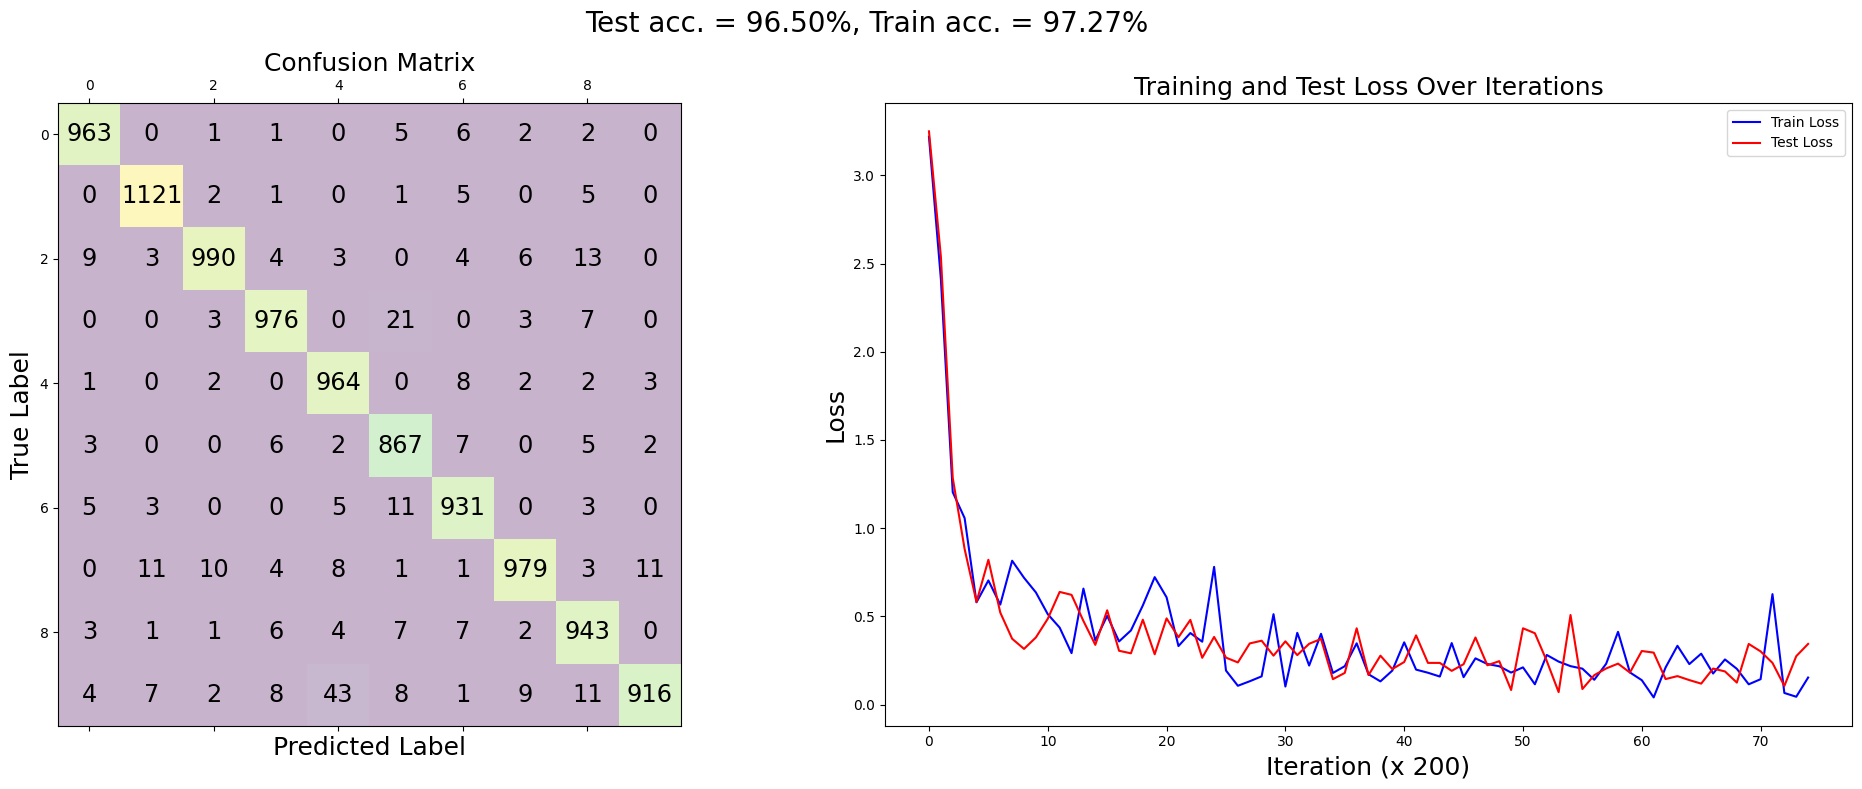

In [27]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "random"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(train_dataloader, test_data, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch, print_cost=True, lambd=lambd, initial=initial)

# Find the model with 'zero' initialization dynamically
i = [key for key in learned_parameters.keys() if "Initilization=random" in key][0]

# Plotting the losses and confusion matrix for the 'zero' initialization model
plotting(learned_parameters[i], test_data, train_data, relu)


Model Key: Epoch=15,alpha=0.01,Regularization=0,Batch=64,Initilization=glorot
Cost after epoch 0, iteration 0: Train Cost: 3.1491358721260605, Test Cost: 3.3040683705318115
Cost after epoch 0, iteration 200: Train Cost: 1.831596902920069, Test Cost: 1.7794557334599364
Cost after epoch 0, iteration 400: Train Cost: 0.9655877335065852, Test Cost: 0.7253630893813604
Cost after epoch 0, iteration 600: Train Cost: 0.7634845119596534, Test Cost: 0.795834219997683
Cost after epoch 0, iteration 800: Train Cost: 0.5908568732004384, Test Cost: 0.37430341658077615
Cost after epoch 1, iteration 0: Train Cost: 0.6118175353574904, Test Cost: 0.5859919017351012
Cost after epoch 1, iteration 200: Train Cost: 0.5498190296460304, Test Cost: 0.9127703129958356
Cost after epoch 1, iteration 400: Train Cost: 0.5206075203096745, Test Cost: 0.6235718979961231
Cost after epoch 1, iteration 600: Train Cost: 0.6809460988549756, Test Cost: 0.3921359297473448
Cost after epoch 1, iteration 800: Train Cost: 0.38770

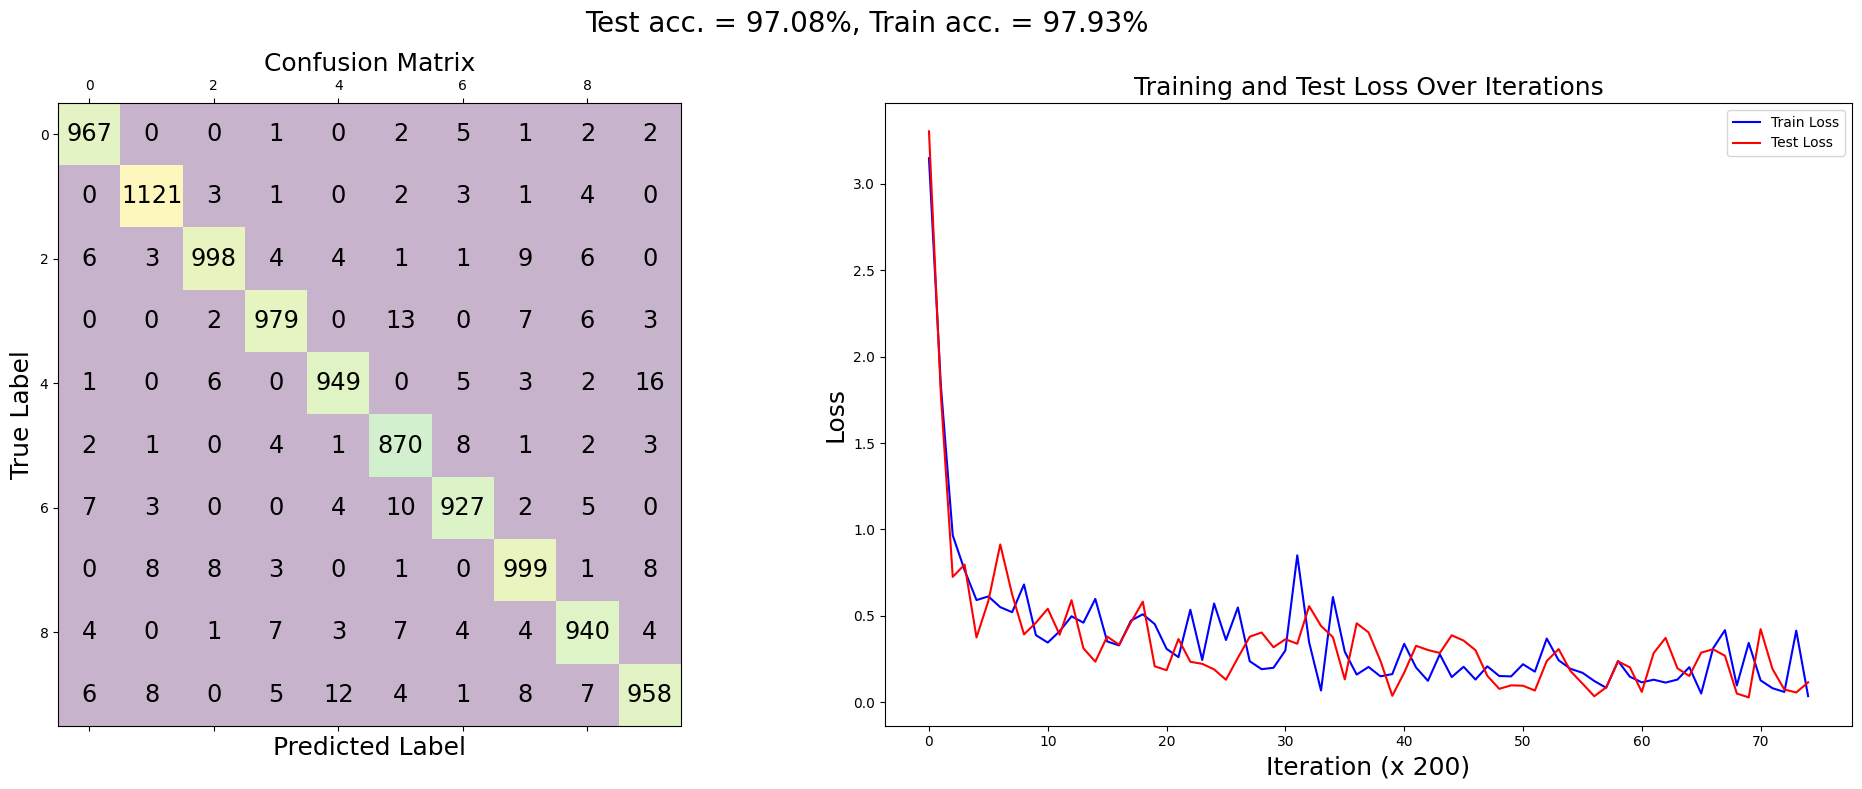

In [28]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.01
lambd = 0
epoch = 15
batch_size = 64
initial = "glorot"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(train_dataloader, test_data, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch, print_cost=True, lambd=lambd, initial=initial)

# Find the model with 'zero' initialization dynamically
i = [key for key in learned_parameters.keys() if "Initilization=glorot" in key][0]

# Plotting the losses and confusion matrix for the 'zero' initialization model
plotting(learned_parameters[i], test_data, train_data, relu)


Model Key: Epoch=15,alpha=0.3,Regularization=0,Batch=64,Initilization=glorot
Cost after epoch 0, iteration 0: Train Cost: 3.2883372797503925, Test Cost: 3.164652938694439
Cost after epoch 0, iteration 200: Train Cost: 0.5495445617672459, Test Cost: 0.5393977916288492
Cost after epoch 0, iteration 400: Train Cost: 0.4678886868713272, Test Cost: 0.34427931200015677
Cost after epoch 0, iteration 600: Train Cost: 0.3875411149755045, Test Cost: 0.24537025804737775
Cost after epoch 0, iteration 800: Train Cost: 0.081398409098252, Test Cost: 0.25773208086718047
Cost after epoch 1, iteration 0: Train Cost: 0.5620622842952194, Test Cost: 0.13857651631660714
Cost after epoch 1, iteration 200: Train Cost: 0.17902305458827256, Test Cost: 0.11872529954200325
Cost after epoch 1, iteration 400: Train Cost: 0.23716930740681794, Test Cost: 0.1191465078989634
Cost after epoch 1, iteration 600: Train Cost: 0.07327337981182346, Test Cost: 0.4096605522003662
Cost after epoch 1, iteration 800: Train Cost: 0

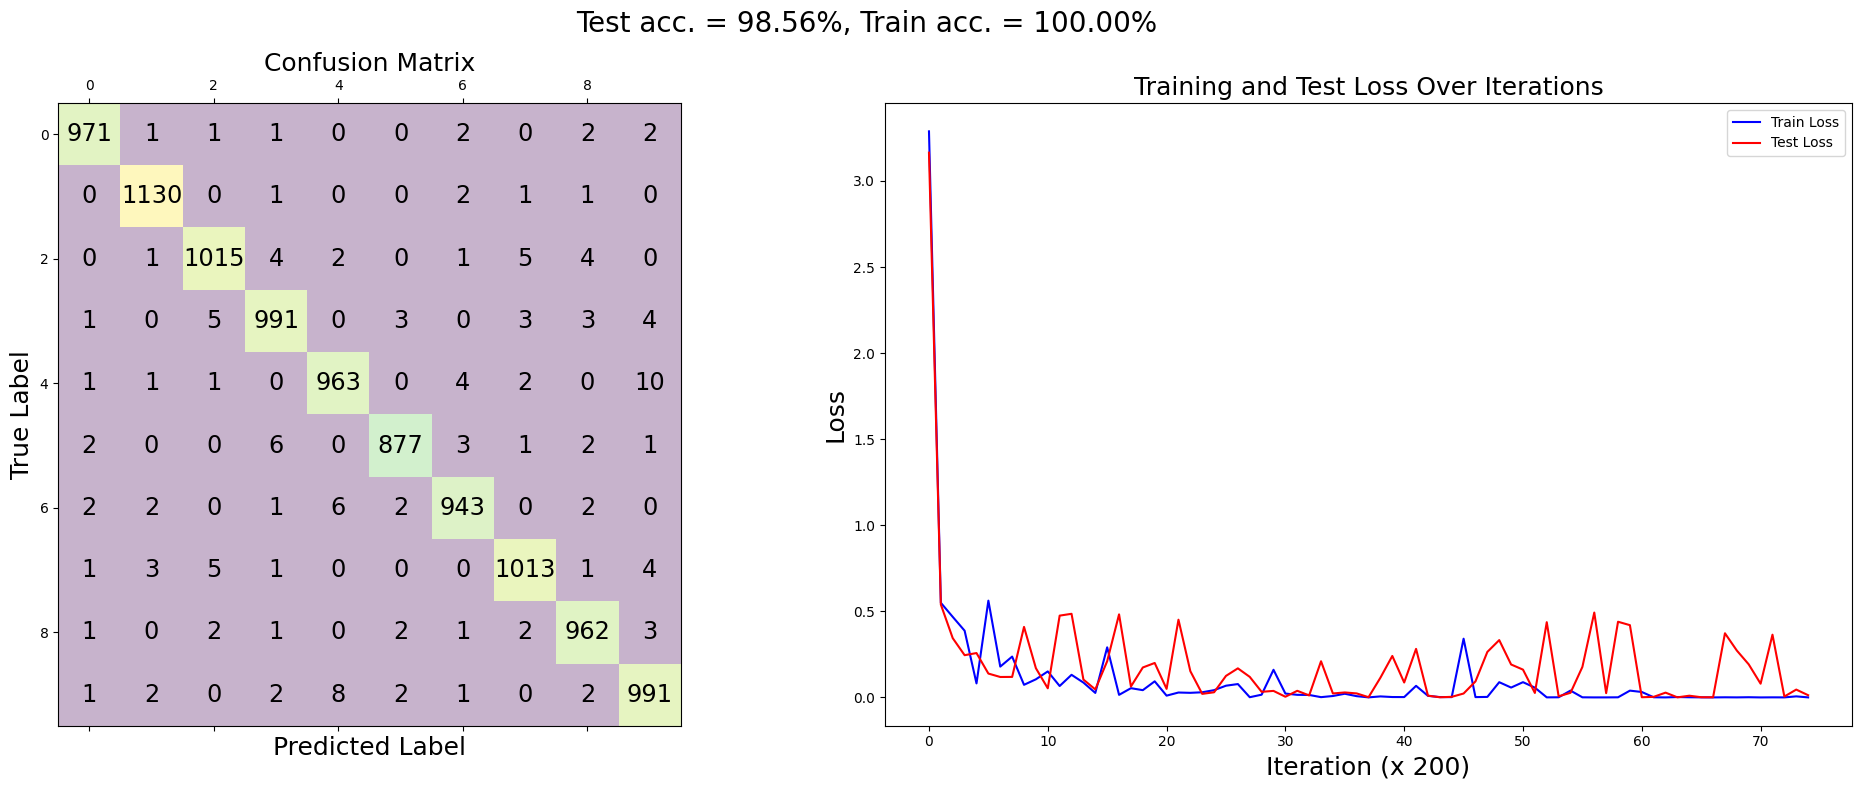

In [29]:
# Dictionary to store learned parameters for different models
learned_parameters = {}

learning_rate = 0.3
lambd = 0
epoch = 15
batch_size = 64
initial = "glorot"
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Create a model name (key) based on training parameters
model_name = "Epoch=" + str(epoch) + ",alpha=" + str(learning_rate) + ",Regularization=" + str(lambd) + ",Batch=" + str(batch_size) + ",Initilization=" + initial
print("Model Key: " + model_name)

# Train the model and store the learned parameters
learned_parameters[model_name] = model(train_dataloader, test_data, batch_size=batch_size, learning_rate=learning_rate, epoch=epoch, print_cost=True, lambd=lambd, initial=initial)

# Find the model with 'zero' initialization dynamically
i = [key for key in learned_parameters.keys() if "Initilization=glorot" in key][0]

# Plotting the losses and confusion matrix for the 'zero' initialization model
plotting(learned_parameters[i], test_data, train_data, relu)
